### Detect face's keypoints

In [1]:
# !pip install tensorflow
# !pip install torch
# !pip install torchvision
# !pip install tqdm
# !pip install --pre torch --index-url https://download.pytorch.org/whl/nightly/cpu
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install -U scikit-learn
# !pip install torchvision
# !pip install tqdm
# !pip install seaborn
# !pip install -U albumentations

### Google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Colab/Fundamentals_Deep_Learning/full_pipeline

!ls

/content/gdrive/MyDrive/Colab/Fundamentals_Deep_Learning/full_pipeline
dataset  full_pipeline.ipynb  full_pipeline_pytorch.ipynb


### Librarys

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import json
# import os
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
import torch
from torchvision import datasets
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F

# from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn import datasets
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, datasets
import seaborn as sns
import albumentations as A
sns.set()


### Data transform

In [5]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()

  def read_dataset(self, filename):
    X = pd.read_csv(filename)
    X.fillna(method = 'ffill', inplace=True)
    X.fillna(value=0, inplace=True)

    return X

  def show_image(self, image):
    plt.imshow(self.transform_image(image))

  def transform_image(self, image):
    return np.reshape(np.array(image.split(' '), dtype=int), (96,96,1))

  def plot_sample(self, image, keypoint,axis, title, true_keypoints=None):
    # image = image.reshape(96,96)
    # sns.imshow(image, cmap='gray', vmin=0, vmax=255, ax=axis)
    axis.imshow(image, cmap='gray', vmin=0, vmax=255)
    # sns.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=20, color='r', ax=axis)
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=20, color='r')
    if true_keypoints:
      # sns.scatter(true_keypoints[0::2], true_keypoints[1::2], marker='x', s=20, color='b', ax=axis)
      axis.scatter(true_keypoints[0::2], true_keypoints[1::2], marker='x', s=20, color='b')

    axis.set_title(title)

  def fit(self, X, y):
    return self

  def transform(self, X: pd.DataFrame, y=None):
    images = X["Image"].apply(self.transform_image)
    keys = X.drop("Image",axis = 1)
    # keys[keys==np.nan] = 0.

    return np.stack(images.to_numpy(), 0), keys.to_numpy()

  def fit_transform(self, X, y = None):
      return self.fit(X, y).transform(X, y)

class CustomMinMax(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.min_max = MinMaxScaler()
  def fit(self, X, y=None):
    # self.min_max.fit(y)
    return self
  def transform(self, X, y=None):
    return X[0]/255., X[1]
    # return X[0]/255., self.min_max.transform(X[1])
  def inverse_transform(self, X, y=None):
    return np.array(X*255, dtype=np.int8), self.min_max.inverse_transform(y)
  def fit_transform(self, X, y=None):
    return self.fit(X, y).transform(X, y)

### Dataset interator

In [6]:
class SelfDataset(Dataset):
  def __init__(self, x_dataset, y_dataset, transform, augmentation_transform=None,  in_train=False):
    super()
    self.in_train = in_train
    self.x_dataset = x_dataset
    self.y_dataset = y_dataset
    self.transform = transform
    self.augmentation_transform = augmentation_transform
    self.width = x_dataset.shape[2]
    self.height = x_dataset.shape[1]

  def __len__(self) -> int:
    return len(self.x_dataset)
  def transform_inverse(self, x, y):
    y_true = y.copy()
    y_true[0::2] = y_true[0::2]*self.width
    y_true[1::2] = y_true[1::2]*self.height
    return (x*255).astype(int), y_true

  def __getitem__(self, idx):
    if self.in_train:
      if np.random.random(1).squeeze()<.15:
        x_ = self.transform(np.zeros(self.x_dataset[idx].shape, dtype=np.float32))
        y_ = torch.tensor(np.zeros(self.y_dataset[idx].shape, dtype=np.float32))
        return x_, y_
      if np.random.random(1).squeeze()<.15:
        x_ = self.transform(np.ones(self.x_dataset[idx].shape, dtype=np.float32))
        y_ = torch.tensor(np.zeros(self.y_dataset[idx].shape, dtype=np.float32))
        return x_, y_
    if self.augmentation_transform:
      image, keypoints =  self.augmentation_transform(image = self.x_dataset[idx].astype(np.float32),
                          keypoints = self.y_dataset[idx].reshape((15, 2)).astype(np.float32)).values()

      keypoints_logs = np.array(keypoints).reshape((-1))
      l_comp = self.y_dataset[idx].shape[0] - keypoints_logs.shape[0]
      keypoints_logs = np.concatenate([keypoints_logs, np.zeros(l_comp)]).astype(np.float32)

      return self.transform(image/255), torch.tensor(keypoints_logs/self.width)
    return (self.transform(self.x_dataset[idx].astype(np.float32)/255),
                        torch.tensor(self.y_dataset[idx].astype(np.float32))/self.width)

### Trainer

In [7]:
from tqdm import tqdm
from torch import nn, optim

class Trainer():
  def __init__(self, model,  batch_size=4, criterion = nn.SmoothL1Loss()):
    # self.criterion = nn.MSELoss()
    self.criterion = criterion
    self.batch_size = batch_size
    self.optimizer = optim.Adam(model.parameters(), lr=0.00001)
    self.cleaner = Cleaner()
    # Create an instance of the ImageFolder dataset

  def fit(self, model, train_dataset, test_dataset, epochs = 50):
    train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
    valid_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
    torch.cuda.empty_cache()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if torch.cuda.is_available():
      model = model.to(device)

    for epoch in np.arange(epochs):
      model.train()
      running_loss = 0.0

      all_targets = []
      all_preds = []
      ## treino
      for x, y in train_dataloader:
        if torch.cuda.is_available():
          x, y = x.to(device), y.to(device)

        self.optimizer.zero_grad()
        outputs = model(x)
        loss = self.criterion(outputs, y)
        if torch.isnan(loss).any():
            print("NaN loss detected")
            break
        loss.backward()
        self.optimizer.step()
        running_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

      # self.model.eval()
      valid_loss = 0.0

      valid_targets = []
      valid_preds = []
      ## validacão
      for x, y in valid_dataloader:
        if torch.cuda.is_available():
          x, y = x.to(device), y.to(device)

        with torch.no_grad():
          outputs = model(x)
          loss = self.criterion(outputs, y)

        if torch.isnan(loss).any():
            print("NaN loss detected")
            break
        valid_loss += loss.item()
        valid_preds.append(outputs.detach().cpu().numpy())
        valid_targets.append(y.detach().cpu().numpy())


      # Calculate Root Mean Squared Error
      all_preds = np.concatenate(all_preds, axis=0)
      all_targets = np.concatenate(all_targets, axis=0)
      train_rmse = np.sqrt(mse(all_targets, all_preds))

      valid_preds = np.concatenate(valid_preds, axis=0)
      valid_targets = np.concatenate(valid_targets, axis=0)
      valid_rmse = np.sqrt(mse(valid_targets, valid_preds))

      print(f"\n Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader)}, RMSE: {train_rmse}")
      print(f"valid Loss: {valid_loss/len(valid_dataloader)}, RMSE: {valid_rmse}")

  def test(self, model, test_dataset):
    torch.cuda.empty_cache()
    test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
    length = len(test_dataloader)
    limiar = int(length*.2)
    limiar = limiar if limiar else 1
    length = length//limiar + 1 if length % limiar > 0 else length//limiar

    fig, ax = plt.subplots(length, 1, figsize=(8,24))
    # fig.dpi(100)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if torch.cuda.is_available():
      model = model.to(device)

    model.eval()
    all_preds = []

    for i, (x, _) in enumerate(test_dataloader):
      if torch.cuda.is_available():
        x = x.to(device)

      with torch.no_grad():
        outputs = model(x)
        if (i % limiar)==0:
          count = int(i / limiar)

          self.cleaner.plot_sample((x[0].detach().cpu().permute(1, 2, 0).numpy()*255)//1,
                              outputs[0].detach().cpu().numpy()*96,
                              ax[count], f"Exemplo {count} com os keypoints")
        all_preds.append(outputs.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)

    plt.tight_layout()
    plt.show()
    return all_preds.reshape((-1))

### Model

In [8]:
class FacialKeypointCNN(nn.Module):
    def __init__(self):
        super(FacialKeypointCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 24 * 24, 1000)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 30)  # assuming 15 keypoints with x and y coordinates

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Replace view with reshape
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x

### Load dataset

In [9]:
cleaner = Cleaner()
file_name_train = "dataset/training.csv"
file_name_test = "dataset/test.csv"

train_data = cleaner.read_dataset(file_name_train)
test_data = cleaner.read_dataset(file_name_test)

train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [10]:
train_data.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,...,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000
mean,66.358588,37.649140,30.306631,37.975901,59.224060,36.675731,73.746775,35.619961,37.214171,38.942849,...,48.374186,62.715884,69.586932,73.195985,33.799680,76.964546,50.425299,74.982529,48.565976,78.979256
std,3.447098,3.152072,3.083087,3.032590,1.537961,1.581946,1.961901,2.184829,1.393110,1.470456,...,4.280038,5.720567,4.932241,3.242852,2.350229,2.578721,2.543271,3.294983,4.266848,5.406621
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082643,35.900605,28.782316,36.327178,59.255347,36.065143,73.942694,34.624653,37.478531,39.355685,...,46.602370,59.292697,65.731401,71.862041,34.232759,77.339429,49.471414,75.963592,46.571821,75.553726
50%,66.493907,37.526919,30.253135,37.812736,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,48.424713,63.451421,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,48.588662,78.704640
75%,68.024628,39.254400,31.768407,39.565928,59.255347,36.499692,73.942694,35.902613,37.478531,39.398041,...,50.330437,66.492686,72.600433,72.591200,34.232759,77.339429,51.599453,75.963592,50.676559,82.236528
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


### Show image example

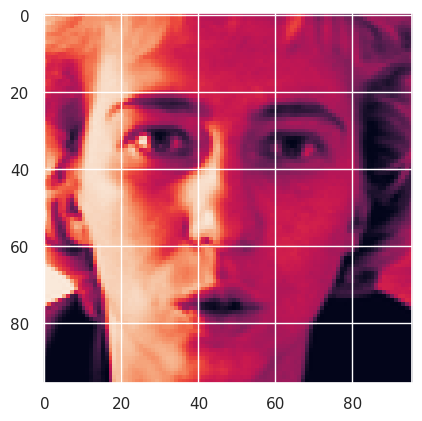

In [11]:
cleaner.show_image(train_data["Image"][1])

In [12]:
train_data.shape

(7049, 31)

In [13]:
limiar = .85
size_train = int(train_data.shape[0]*limiar)
pipeline = Pipeline([
  ("cleaner", cleaner),
  # ("min_max", CustomMinMax()),
])
x_train, y_train = pipeline.fit_transform(train_data.iloc[:size_train].copy(), [])
x_valid, y_valid = pipeline.transform(train_data.iloc[size_train:].copy())
# x_test, y_test = pipeline.transform(test_data)

In [14]:
y_train.tolist()

[[66.0335639098,
  39.0022736842,
  30.2270075188,
  36.4216781955,
  59.582075188,
  39.6474225564,
  73.1303458647,
  39.9699969925,
  36.3565714286,
  37.3894015038,
  23.4528721805,
  37.3894015038,
  56.9532631579,
  29.0336481203,
  80.2271278195,
  32.2281383459,
  40.2276090226,
  29.0023218045,
  16.3563789474,
  29.6474706767,
  44.4205714286,
  57.0668030075,
  61.1953082707,
  79.9701654135,
  28.6144962406,
  77.3889924812,
  43.3126015038,
  72.9354586466,
  43.1307067669,
  84.4857744361],
 [64.3329361702,
  34.9700765957,
  29.9492765957,
  33.4487148936,
  58.8561702128,
  35.2743489362,
  70.7227234043,
  36.1871659574,
  36.0347234043,
  34.3615319149,
  24.4725106383,
  33.1444425532,
  53.9874042553,
  28.2759489362,
  78.634212766,
  30.4059234043,
  42.7288510638,
  26.1460425532,
  16.8653617021,
  27.0588595745,
  48.2062978723,
  55.6609361702,
  56.4214468085,
  76.352,
  35.1223829787,
  76.0476595745,
  46.6845957447,
  70.2665531915,
  45.4679148936,
  85.

In [15]:
x_train[0].shape

(96, 96, 1)

### show image example with keypoints

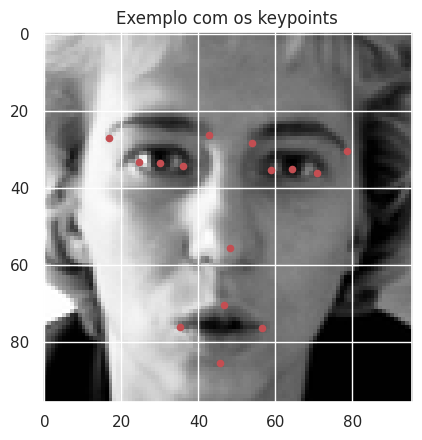

In [16]:
fig, ax = plt.subplots()
i = 1
cleaner.plot_sample(x_train[i], y_train[i], ax, "Exemplo com os keypoints")


In [17]:
x_train.shape

(5991, 96, 96, 1)

In [18]:
y_train.shape

(5991, 30)

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# batch_size = 8

In [20]:
y_train[0][0::2], y_train[0][1::2]

(array([66.03356391, 30.22700752, 59.58207519, 73.13034586, 36.35657143,
        23.45287218, 56.95326316, 80.22712782, 40.22760902, 16.35637895,
        44.42057143, 61.19530827, 28.61449624, 43.3126015 , 43.13070677]),
 array([39.00227368, 36.4216782 , 39.64742256, 39.96999699, 37.3894015 ,
        37.3894015 , 29.03364812, 32.22813835, 29.0023218 , 29.64747068,
        57.06680301, 79.97016541, 77.38899248, 72.93545865, 84.48577444]))

### Load configs

In [21]:
# Define the data transformation pipeline
# train_transform = T.Compose([
#     T.RandomRotation(90),
#     # # transforms.CenterCrop(224),
#     T.RandomAffine(degrees=90, translate=(0.1, 0.1)),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
#     # T.Normalize(mean=[0.45], std=[0.22], inplace=True),
#     # T.ConvertImageDtype(torch.float)
#     ])#, additional_targets={'target': 'target'}

data_transform = T.Compose([
    T.ToTensor(),             # Convert image to tensor
    ],)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


como o dataset já tem uma implementação de data augmentation, sendo assim reduzir a probabilidade para modificação na aplicacão no modelo.

In [22]:
aug_transform = A.Compose([
    A.RandomCrop(width=96, height=96),
    A.RandomBrightnessContrast(p=0.01),
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=25, p=0.5),
    A.HorizontalFlip(p=0.1)
], keypoint_params=A.KeypointParams(format="xy"))

In [23]:
model = FacialKeypointCNN()
trainer = Trainer(
  model,
  batch_size=64,
  # criterion=nn.HuberLoss()
  criterion=nn.MSELoss()
)

### Train

In [24]:
trainer.fit(model,
            SelfDataset(x_train, y_train, data_transform, aug_transform, in_train=False),
            SelfDataset(x_valid, y_valid, data_transform, None),
            epochs=20)


 Epoch 1/20, Loss: 0.02697194407277919, RMSE: 0.16444608569145203
valid Loss: 0.002230787382680265, RMSE: 0.047433629631996155

 Epoch 2/20, Loss: 0.008478441520871476, RMSE: 0.09219709783792496
valid Loss: 0.0018706916872521535, RMSE: 0.04339989274740219

 Epoch 3/20, Loss: 0.007926468861269508, RMSE: 0.08903635293245316
valid Loss: 0.0012251867892165832, RMSE: 0.035149890929460526

 Epoch 4/20, Loss: 0.007543716572244909, RMSE: 0.08688558638095856
valid Loss: 0.0009296930819640265, RMSE: 0.03063173219561577

 Epoch 5/20, Loss: 0.007487572675095277, RMSE: 0.08656458556652069
valid Loss: 0.0013411343029207166, RMSE: 0.03674565255641937

 Epoch 6/20, Loss: 0.008119526797251657, RMSE: 0.0900241807103157
valid Loss: 0.0015529097838546423, RMSE: 0.039515502750873566

 Epoch 7/20, Loss: 0.007619751406774083, RMSE: 0.08733480423688889
valid Loss: 0.0008623914293232648, RMSE: 0.029491199180483818

 Epoch 8/20, Loss: 0.00766754255659799, RMSE: 0.08757080137729645
valid Loss: 0.000954422880621

### Run test in the model

In [31]:
test_data.head(5)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [32]:
x_test, y_test = cleaner.transform(test_data)

In [33]:
x_test[50].shape

(96, 96, 1)

(96, 96, 1)

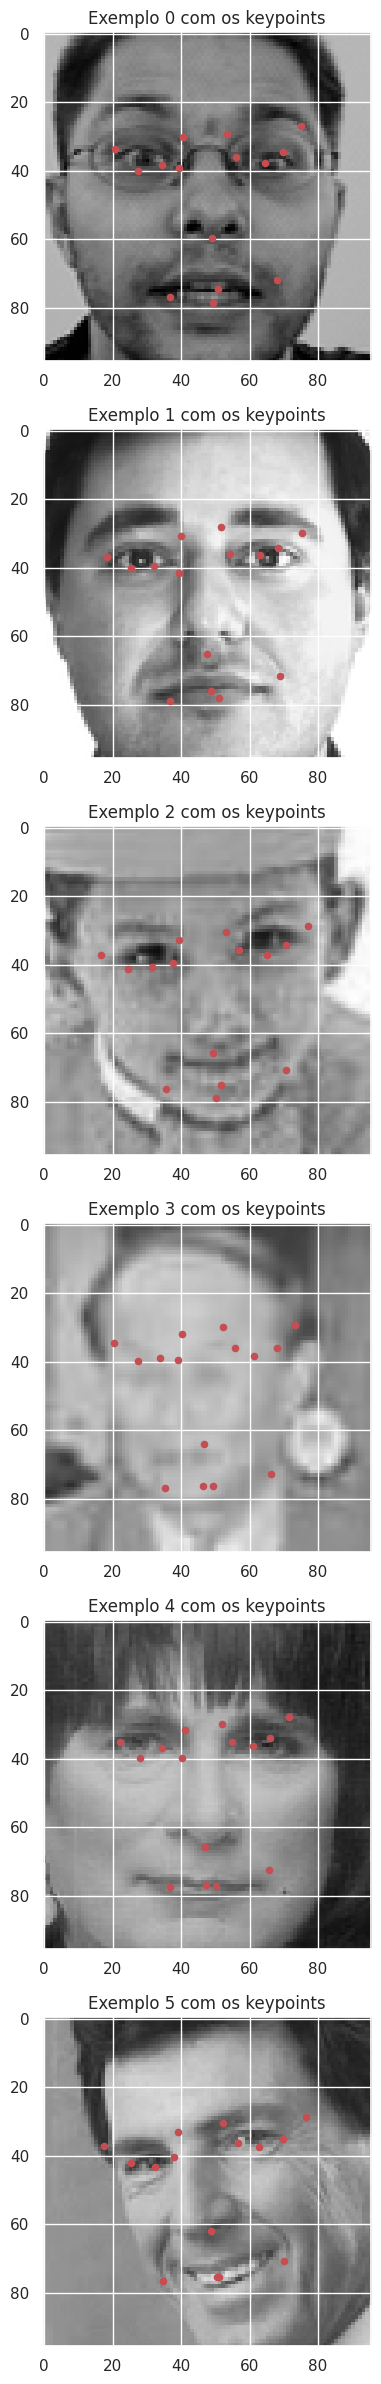

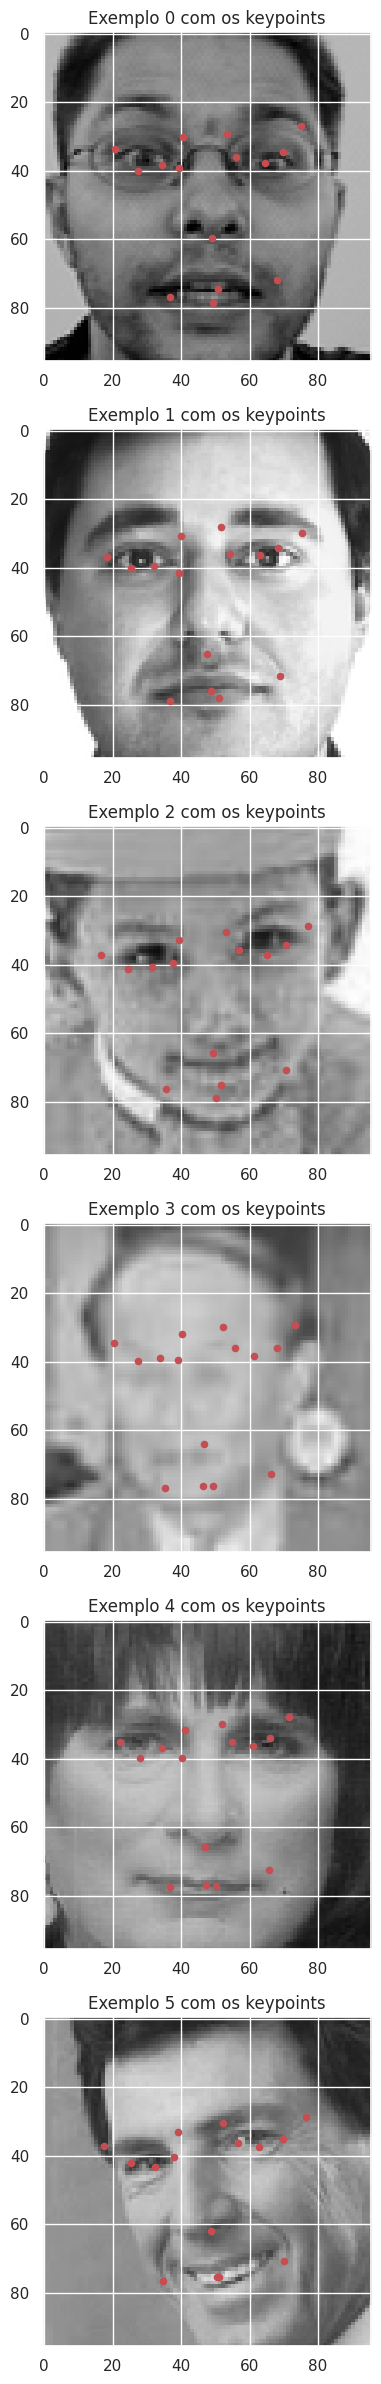

In [34]:
# file_name_submission = "dataset/IdLookupTable.csv"
# submission = cleaner.read_dataset(file_name_submission)
keypoint_find = trainer.test(model,
            SelfDataset(x_test, y_test, data_transform),)

In [35]:
keypoint_find.shape

(53490,)

(53490,)

In [36]:
submission = pd.DataFrame(data=(keypoint_find*96), columns=["Location"])
submission.to_csv("dataset/submission.csv")
keypoint_find.shape

(53490,)

(53490,)